In [211]:
import librosa
import os
from sklearn.model_selection import train_test_split
from preprocess import *
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import display

In [19]:
############################################################
# Pre Processing
############################################################

DATA_PATH = "./data/"

def save_data_to_array(path=DATA_PATH, max_len=11, n_mfcc=20):
    labels, _, _ = get_labels(path)

    for label in labels:

        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=n_mfcc)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)
        
def get_labels(path=DATA_PATH):
    
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

def get_train_test(split_ratio=0.6, random_state=42):

    labels, indices, _ = get_labels(DATA_PATH)

    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    for ii, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (ii + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

def wav2mfcc(file_path, n_mfcc=20, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [51]:
############################################################
# Importing Data
############################################################

max_len = 11
buckets = 20

save_data_to_array(max_len = max_len, n_mfcc = buckets)

labels = ['bed', 'happy', 'cat']

Saving vectors of label - 'happy': 100%|████████████████████████████████████████████| 736/736 [00:02<00:00, 322.03it/s]


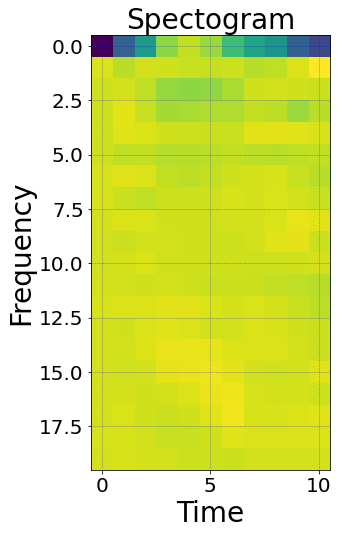

In [92]:
############################################################
# Data Management
############################################################

X_train, X_test, y_train, y_test = get_train_test()

channels = 1

num_classes = len(labels)

X_CNN_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_CNN_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

X_LSTM_train = X_train.reshape(X_train.shape[0], buckets, max_len)
X_LSTM_test = X_test.reshape(X_test.shape[0], buckets, max_len)

y_train_class = to_categorical(y_train)
y_test_class = to_categorical(y_test)

plt.figure(figsize = (12, 8))
plt.imshow(X_LSTM_train[100, :, :])
plt.title('Spectogram', size = 28)
plt.xlabel('Time', size = 28)
plt.ylabel('Frequency', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
plt.show()

In [206]:
############################################################
# CNN Architecture
############################################################

learning_rate = 0.0001

CNN_model = Sequential()


CNN_model.add(Conv2D(64, (3, 3), activation = 'relu',
                     input_shape = (buckets, max_len, channels),
                     kernel_regularizer = keras.regularizers.l2(0.001)))
CNN_model.add(keras.layers.BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'))


CNN_model.add(Conv2D(32, (3, 3), activation = 'relu',
                     kernel_regularizer = keras.regularizers.l2(0.001)))
CNN_model.add(keras.layers.BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'))


CNN_model.add(Conv2D(32, (2, 2), activation = 'relu',
                     kernel_regularizer = keras.regularizers.l2(0.001)))
CNN_model.add(keras.layers.BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))


CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation = 'relu'))
CNN_model.add(Dropout(0.3))


CNN_model.add(Dense(num_classes, activation = 'softmax'))


opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

CNN_model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = 'accuracy')


CNN_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 18, 9, 64)         640       
                                                                 
 batch_normalization_24 (Bat  (None, 18, 9, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 9, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 3, 32)          18464     
                                                                 
 batch_normalization_25 (Bat  (None, 7, 3, 32)         128       
 chNormalization)                                                
                                                     

Epoch 1/50
52/52 [==============================] - 1s 12ms/step - loss: 1.7261 - accuracy: 0.3236 - val_loss: 1.6469 - val_accuracy: 0.3032
Epoch 2/50
52/52 [==============================] - 1s 10ms/step - loss: 1.3374 - accuracy: 0.4028 - val_loss: 1.2797 - val_accuracy: 0.3963
Epoch 3/50
52/52 [==============================] - 1s 10ms/step - loss: 1.1761 - accuracy: 0.4790 - val_loss: 1.0951 - val_accuracy: 0.5005
Epoch 4/50
52/52 [==============================] - 1s 10ms/step - loss: 1.0870 - accuracy: 0.5186 - val_loss: 0.9893 - val_accuracy: 0.5854
Epoch 5/50
52/52 [==============================] - 1s 10ms/step - loss: 0.9973 - accuracy: 0.5661 - val_loss: 0.9188 - val_accuracy: 0.6247
Epoch 6/50
52/52 [==============================] - 1s 10ms/step - loss: 0.9056 - accuracy: 0.6362 - val_loss: 0.8606 - val_accuracy: 0.6566
Epoch 7/50
52/52 [==============================] - 1s 10ms/step - loss: 0.8305 - accuracy: 0.6697 - val_loss: 0.8005 - val_accuracy: 0.7087
Epoch 8/50
52

INFO:tensorflow:Assets written to: CNN_model.model\assets


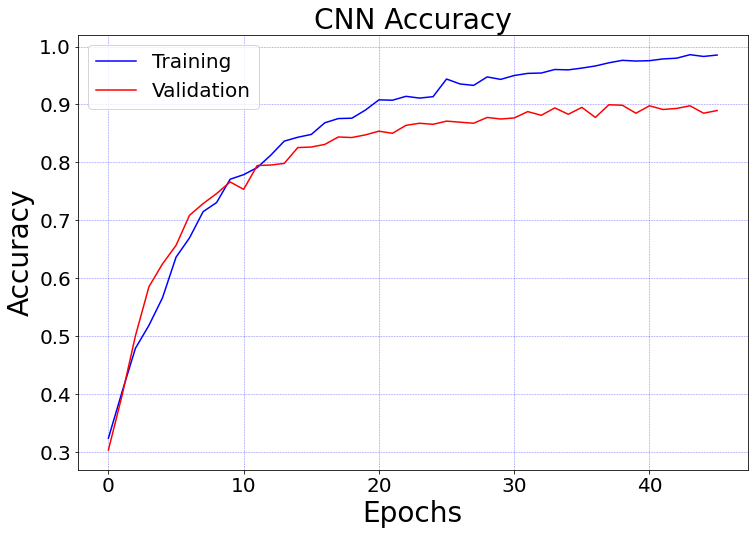

In [207]:
############################################################
# CNN Training
############################################################

epochs = 50
batch_size = 32
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

CNN_history = CNN_model.fit(X_CNN_train, y_train_class,
                            epochs = epochs,
                            batch_size = batch_size,
                            validation_data = (X_test, y_test_class),
                            callbacks = [early_stop])

CNN_model.save('CNN_model.model')

plt.figure(figsize = (12, 8))
plt.plot(CNN_history.history['accuracy'], label = 'Training', color = 'b')
plt.plot(CNN_history.history['val_accuracy'], label = 'Validation', color = 'r')
plt.title('CNN Accuracy', size = 28)
plt.xlabel('Epochs', size = 28)
plt.ylabel('Accuracy', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
plt.show()

In [208]:
############################################################
# RNN-LSTM Architecture
############################################################

learning_rate = 0.0001


LSTM_model = Sequential()


LSTM_model.add(LSTM(128, input_shape=(buckets, max_len), activation="sigmoid"))
LSTM_model.add(Dropout(0.3))


LSTM_model.add(Dense(num_classes, activation='softmax'))


opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

LSTM_model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = 'accuracy')

LSTM_model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 128)               71680     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 3)                 387       
                                                                 
Total params: 72,067
Trainable params: 72,067
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
52/52 [==============================] - 1s 16ms/step - loss: 1.1694 - accuracy: 0.3534 - val_loss: 1.1113 - val_accuracy: 0.3699
Epoch 2/50
52/52 [==============================] - 1s 14ms/step - loss: 1.1295 - accuracy: 0.3656 - val_loss: 1.0935 - val_accuracy: 0.3799
Epoch 3/50
52/52 [==============================] - 1s 14ms/step - loss: 1.1043 - accuracy: 0.3967 - val_loss: 1.0864 - val_accuracy: 0.3881
Epoch 4/50
52/52 [==============================] - 1s 14ms/step - loss: 1.0871 - accuracy: 0.4205 - val_loss: 1.0805 - val_accuracy: 0.3973
Epoch 5/50
52/52 [==============================] - 1s 14ms/step - loss: 1.1080 - accuracy: 0.3845 - val_loss: 1.0771 - val_accuracy: 0.4100
Epoch 6/50
52/52 [==============================] - 1s 14ms/step - loss: 1.0945 - accuracy: 0.4071 - val_loss: 1.0731 - val_accuracy: 0.4219
Epoch 7/50
52/52 [==============================] - 1s 13ms/step - loss: 1.0940 - accuracy: 0.3973 - val_loss: 1.0694 - val_accuracy: 0.4365
Epoch 8/50
52

INFO:tensorflow:Assets written to: LSTM_model.model\assets


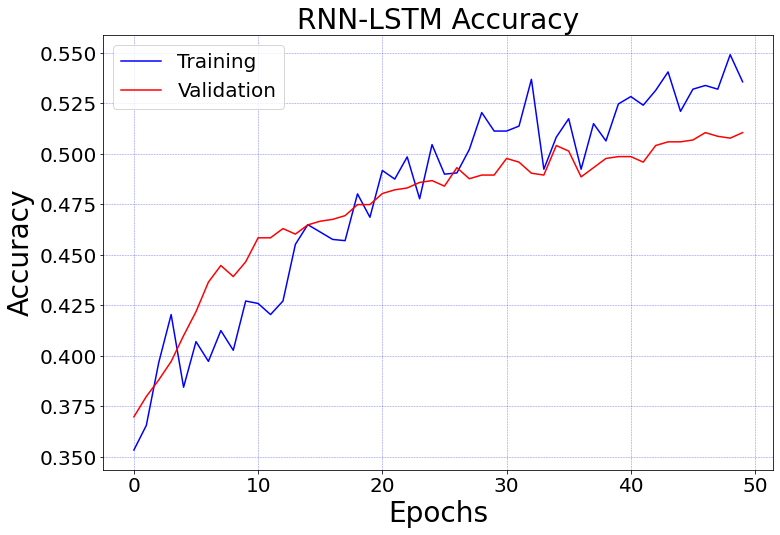

In [209]:
############################################################
# RNN-LSTM Training
############################################################

epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

LSTM_history = LSTM_model.fit(X_LSTM_train, y_train_class,
                              epochs = epochs,
                              validation_data = (X_test, y_test_class),
                              callbacks = [early_stop])

LSTM_model.save('LSTM_model.model')

plt.figure(figsize = (12, 8))
plt.plot(LSTM_history.history['accuracy'], label = 'Training', color = 'b')
plt.plot(LSTM_history.history['val_accuracy'], label = 'Validation', color = 'r')
plt.title('RNN-LSTM Accuracy', size = 28)
plt.xlabel('Epochs', size = 28)
plt.ylabel('Accuracy', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
plt.show()

,bed,happy,cat
Real,398,407,290
CNN,389,398,308
LSTM,518,516,61


<Figure size 432x288 with 0 Axes>

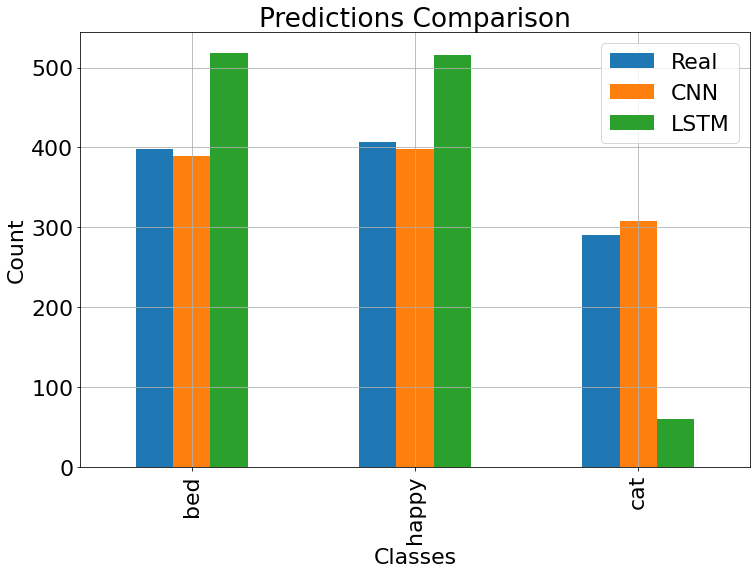

In [210]:
############################################################
# Predictions
############################################################

CNN_model = tf.keras.models.load_model('CNN_model.model')
LSTM_model = tf.keras.models.load_model('LSTM_model.model')

CNN_prediction = CNN_model.predict(X_CNN_test)

LSTM_prediction = LSTM_model.predict(X_LSTM_test)

CNN_predicted_class = []
LSTM_predicted_class = []

for ii in range(CNN_prediction.shape[0]):

    CNN_predicted_class.append(np.argmax(CNN_prediction[ii, :]))
    LSTM_predicted_class.append(np.argmax(LSTM_prediction[ii, :]))
    
_, CNN_counts = np.unique(CNN_predicted_class, return_counts=True)
_, LSTM_counts = np.unique(LSTM_predicted_class, return_counts=True)
_, y_counts = np.unique(y_test, return_counts=True)

results_dict = {'Real': y_counts, 'CNN': CNN_counts, 'LSTM': LSTM_counts}

results_data = pd.DataFrame.from_dict(results_dict, orient='index',
                                      columns = labels)

plt.figure()
plt.rcParams.update({'font.size': 22})
ax = results_data.T.plot(kind = 'bar', 
                  figsize = (12, 8), 
                  grid = True,
                  ylabel = 'Count',
                  xlabel = 'Classes',
                  title = 'Predictions Comparison')

display(results_data)